### import statements 

In [5]:
import yfinance as yf 
import pandas as pd 
import numpy as np
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,roc_curve, roc_auc_score


### download data

In [6]:
ticker = yf.Ticker('^N225')
data = ticker.history(period = '2y')
print(data.head())

                                   Open          High           Low  \
Date                                                                  
2022-11-14 00:00:00+09:00  28277.640625  28305.039062  27963.470703   
2022-11-15 00:00:00+09:00  27940.259766  28038.630859  27903.269531   
2022-11-16 00:00:00+09:00  28020.490234  28069.250000  27743.150391   
2022-11-17 00:00:00+09:00  27952.210938  28029.619141  27910.009766   
2022-11-18 00:00:00+09:00  28009.820312  28045.439453  27877.779297   

                                  Close    Volume  Dividends  Stock Splits  
Date                                                                        
2022-11-14 00:00:00+09:00  27963.470703  85100000        0.0           0.0  
2022-11-15 00:00:00+09:00  27990.169922  71200000        0.0           0.0  
2022-11-16 00:00:00+09:00  28028.300781  73200000        0.0           0.0  
2022-11-17 00:00:00+09:00  27930.570312  58900000        0.0           0.0  
2022-11-18 00:00:00+09:00  27899.769531 

### clean data

In [7]:
# drop rows with missing values 
data = data.dropna()
# check for and drop duplicate dates 
data = data[~data.index.duplicated(keep='first')]
# print('cols',data.columns)

### feature engineering

In [8]:
# window lengths for feature calculation 
short_window = 20  # short term ma window 
long_window = 50   # long term ma window 
vol_window = 20    # volatility window 

# moving averages 
data['sma_20'] = data['Close'].rolling(window=short_window).mean()
data['sma_50'] = data['Close'].rolling(window=long_window).mean()

# exponential moving average (EMA)
data['ema_20'] = data['Close'].ewm(span=short_window,adjust=False).mean()
data['ema_50'] = data['Close'].ewm(span=short_window,adjust=False).mean()

#relative strength index (rsi)
delta = data['Close'].diff(1) 
gain = delta.where(delta>0,0)
loss = -delta.where(delta<0,0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain/avg_loss

data['rsi'] = 100 - (100 / (1 +rs))

# volatility (rolling standard deviation of returns)
data['volatility'] = data['Close'].pct_change().rolling(window=vol_window).std()

# momentum (price difference over the period)
data['momentum'] = data['Close'] - data['Close'].shift(short_window)

# moving average convergence divergence (macd)
data['ema_12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['ema_26'] = data['Close'].ewm(span=26, adjust=False).mean()
data['macd'] = data['ema_12'] - data['ema_26']

data['signal_line'] = data['macd'].ewm(span=9, adjust=False).mean()
data['macd_histogram'] = data['macd'] - data['signal_line']
data = data.dropna()
print(data.tail())


                                   Open          High           Low  \
Date                                                                  
2024-11-07 00:00:00+09:00  39745.230469  39884.011719  39020.218750   
2024-11-08 00:00:00+09:00  39783.449219  39818.410156  39377.871094   
2024-11-11 00:00:00+09:00  39417.210938  39598.738281  39315.609375   
2024-11-12 00:00:00+09:00  39642.781250  39866.718750  39137.890625   
2024-11-13 00:00:00+09:00  39317.148438  39377.238281  38600.261719   

                                  Close     Volume  Dividends  Stock Splits  \
Date                                                                          
2024-11-07 00:00:00+09:00  39381.410156  190000000        0.0           0.0   
2024-11-08 00:00:00+09:00  39500.371094  159300000        0.0           0.0   
2024-11-11 00:00:00+09:00  39533.320312  122700000        0.0           0.0   
2024-11-12 00:00:00+09:00  39376.089844  163000000        0.0           0.0   
2024-11-13 00:00:00+09:00  3

### plot 

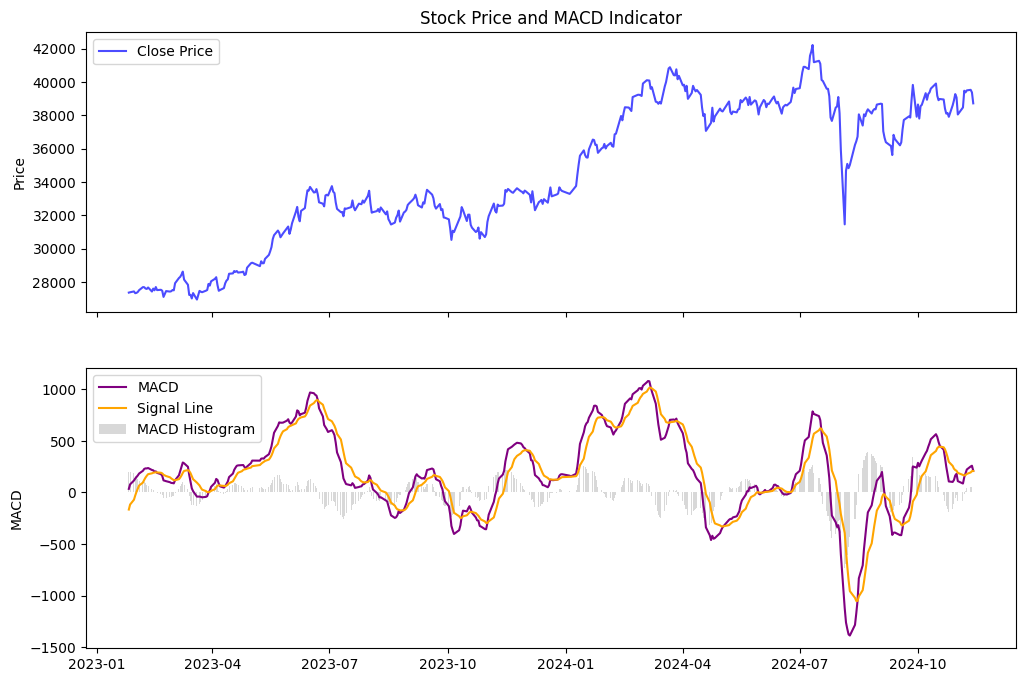

In [9]:
# Set up the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)
# Plot the Closing Price
ax1.plot(data['Close'], label='Close Price', color='blue', alpha=0.7)
ax1.set_title("Stock Price and MACD Indicator")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")
# Plot the MACD and Signal Line
ax2.plot(data['macd'], label='MACD', color='purple', linewidth=1.5)
ax2.plot(data['signal_line'], label='Signal Line', color='orange', linewidth=1.5)
# Plot the MACD Histogram as a bar plot
ax2.bar(data.index, data['macd_histogram'], label='MACD Histogram', color='grey', alpha=0.3)
# Set labels and title for the MACD plot
ax2.set_ylabel("MACD")
ax2.legend(loc="upper left")
# Display the plot
plt.show()

### define long - short labels

In [10]:
data['position'] = np.nan
# define long position(1) when macd crosses above signal line 
data.loc[data['macd'] > data['signal_line'], 'position'] = 1 
# define short position(-1) when macd crosses below signal line 
data.loc[data['macd'] < data['signal_line'], 'position'] = -1 

data['position'] = data['position'].ffill()
display(data.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,sma_20,sma_50,ema_20,ema_50,rsi,volatility,momentum,ema_12,ema_26,macd,signal_line,macd_histogram,position
Date,,,,,,,,,,,,,,,,,,,,
2024-11-07 00:00:00+09:00,39745.230469,39884.011719,39020.218750,39381.410156,190000000,0.0,0.0,38901.779102,38211.528594,38756.994064,38756.994064,54.412138,0.012271,443.871094,38860.938570,38675.031304,185.907266,169.430036,16.477230,1.0
2024-11-08 00:00:00+09:00,39783.449219,39818.410156,39377.871094,39500.371094,159300000,0.0,0.0,38912.899609,38239.331641,38827.791877,38827.791877,54.822500,0.012138,222.410156,38959.312804,38736.167585,223.145220,180.173073,42.972147,1.0
2024-11-11 00:00:00+09:00,39417.210938,39598.738281,39315.609375,39533.320312,122700000,0.0,0.0,38920.521094,38264.225625,38894.985061,38894.985061,55.375531,0.012127,152.429688,39047.621652,38795.215935,252.405717,194.619602,57.786115,1.0
2024-11-12 00:00:00+09:00,39642.781250,39866.718750,39137.890625,39376.089844,163000000,0.0,0.0,38909.035547,38284.312187,38940.804564,38940.804564,59.646135,0.012092,-229.710938,39098.155220,38838.243632,259.911588,207.677999,52.233589,1.0
2024-11-13 00:00:00+09:00,39317.148438,39377.238281,38600.261719,38721.660156,0,0.0,0.0,38849.591016,38291.494766,38919.933668,38919.933668,55.770084,0.012470,-1188.890625,39040.232902,38829.607819,210.625083,208.267416,2.357668,1.0


### further cleaning data

In [11]:
# check for class balance 
print(len(data.loc[data['position'] == 1.0]))
print(len(data.loc[data['position'] == -1.0]))
print(len(data))

249
194
443


### build and train random forest classifier

In [12]:
# define features and target
features = ['macd','signal_line','rsi','sma_20','ema_20','ema_50']
target = 'position'

# prep features and target var 
x = data[features]
y = data[target]

# drop rows with missiing values 
x = x.dropna()
y = y[x.index] # make sure target var matches the features 

# split the data 
x_train, x_test, y_train,y_test = train_test_split(x,y, test_size=0.2,shuffle=True)
# print(len(x_train),len(x_test))

# initialize random forest classifier 
rf_model = RandomForestClassifier(max_depth = 10, min_samples_leaf=5, n_estimators=100, random_state=42,oob_score=True)
# train the model 
rf_model.fit(x_train,y_train)

# make predictions on the test set 
y_pred = rf_model.predict(x_test)
# evaluate the model 
accuracy = accuracy_score(y_test,y_pred)
print('accuracy: ',accuracy)
print('classification report: ', classification_report(y_test,y_pred))
print('confusion matrix: ',confusion_matrix(y_test,y_pred))

accuracy:  0.8876404494382022
classification report:                precision    recall  f1-score   support

        -1.0       0.93      0.78      0.85        36
         1.0       0.86      0.96      0.91        53

    accuracy                           0.89        89
   macro avg       0.90      0.87      0.88        89
weighted avg       0.89      0.89      0.89        89

confusion matrix:  [[28  8]
 [ 2 51]]


In [13]:
# check oob score, becuase random forest classfiier immediately creates this as a validation set 
print(rf_model.oob_score_)


0.9322033898305084


In [14]:
# plot roc auc 

# predict probabilities for the positive class 
y_probs = rf_model.predict_proba(x_test)[:,1]
# calculate roc curve 
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
# calculate auc 
roc_auc = roc_auc_score(y_test, y_probs)



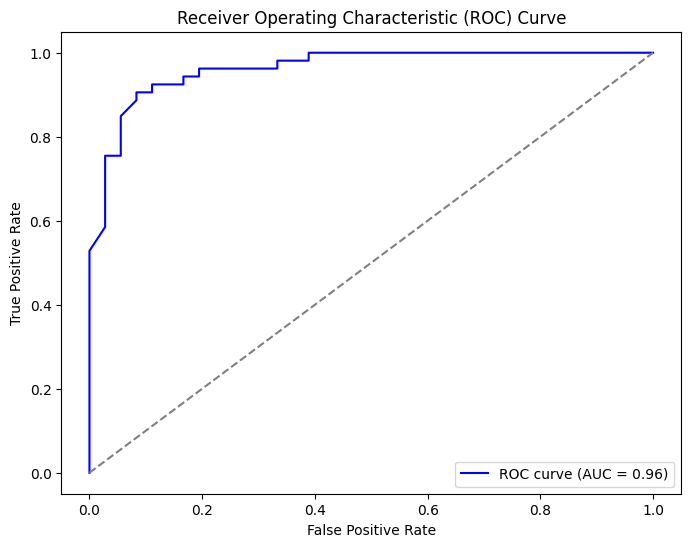

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line for random performance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### hyperparameter tuning 

In [18]:
from sklearn.model_selection import GridSearchCV
import time

In [19]:
%%time
# set the parameters that we want to search 
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


/Users/ilanazane/Desktop/code/myenv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


CPU times: user 1.94 s, sys: 325 ms, total: 2.27 s
Wall time: 23.3 s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

### plot feature importance

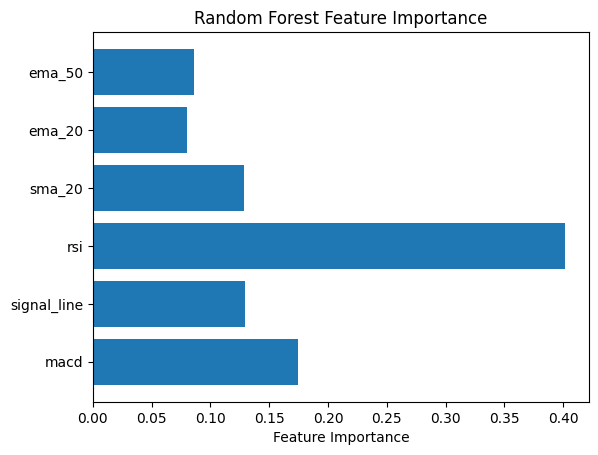

'decision tree.pdf'

In [16]:
feature_importance = rf_model.feature_importances_
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

# visualize one of the classifiers 
dot_data = export_graphviz(rf_model.estimators_[0], 
                             out_file=None, 
                             feature_names = x.columns, 
                             class_names=['-1','1'],
                             filled=True,
                             rounded=True,
                             special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision tree",format='png',cleanup=True)
graph.view()

### generate predictions

In [40]:
data['predicted_position'] = rf_model.predict(x)
final = data[['position', 'predicted_position']]



In [41]:
display(data.loc[data['position'] != data['predicted_position']])
print(len(data))


,Open,High,Low,Close,Volume,Dividends,Stock Splits,sma_20,sma_50,ema_20,...,rsi,volatility,momentum,ema_12,ema_26,macd,signal_line,macd_histogram,position,predicted_position
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-25 00:00:00+09:00,31302.509766,31466.919922,31195.580078,31269.919922,78700000,0.0,0.0,31597.691309,32122.819609,31678.628901,...,57.970678,0.013278,-1045.130859,31506.207344,31778.585800,-272.378456,-225.425469,-46.952987,-1.0,1.0
2024-03-21 00:00:00+09:00,40511.550781,40823.320312,40452.191406,40815.660156,157200000,0.0,0.0,39404.654883,37574.451172,39161.944064,...,66.984067,0.011492,2452.050781,39508.083995,38865.594000,642.489995,675.148566,-32.658571,-1.0,1.0
2024-05-08 00:00:00+09:00,38677.570312,38749.351562,38159.851562,38202.371094,120100000,0.0,0.0,38472.467578,39202.803672,38482.605935,...,42.425652,0.013472,-789.707031,38317.056118,38573.339758,-256.283641,-304.654992,48.371351,1.0,-1.0
2024-09-20 00:00:00+09:00,37714.070312,37974.718750,37654.109375,37723.910156,162600000,0.0,0.0,37325.041992,37769.725742,37058.152623,...,42.891861,0.015167,-487.101562,36924.359036,37170.981483,-246.622447,-305.485798,58.863351,1.0,-1.0
2024-10-21 00:00:00+09:00,38960.199219,39119.671875,38775.589844,38954.601562,99000000,0.0,0.0,38816.561719,37782.650859,38730.696682,...,59.299850,0.017751,1799.273438,38989.781032,38573.288813,416.492219,438.833174,-22.340956,-1.0,1.0
2024-11-06 00:00:00+09:00,38677.949219,39664.531250,38662.171875,39480.671875,170600000,0.0,0.0,38879.585547,38191.185781,38691.266054,...,52.731370,0.012487,147.933594,38766.307372,38618.520996,147.786377,165.310729,-17.524352,-1.0,1.0


443
